<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/Copy_of_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [45]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [46]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [47]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

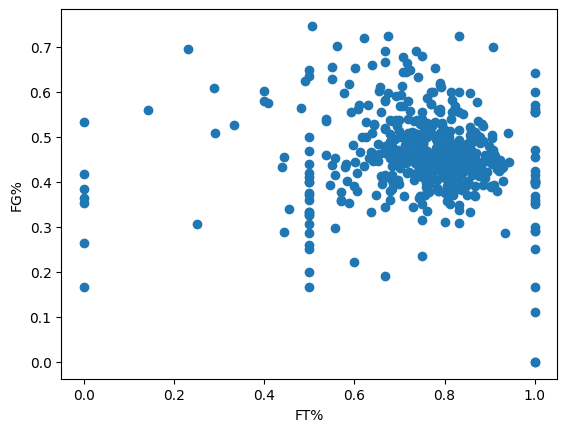

In [48]:
plt.scatter(basketball['FT%'] , basketball['FG%'])
plt.xlabel("FT%")
plt.ylabel("FG%")

I notice that most of the data is concentrated among the right side of the graph. This is likely because professional NBA players are selected for a reason and are skilled in shooting shots. As a result they tend to have high FT% and FG%. Another observation is the 3 vertical lines at free throw percentages of 0, .5 and 1. This may be because not all players shoot free throws often so those who do only one or two times have percentages that are nice and even. They do however, have varying field goal percentages because those are more commonly shot.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

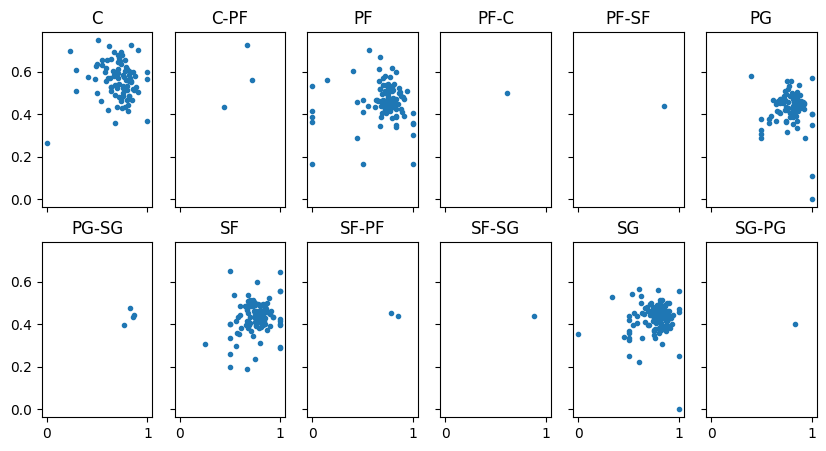

In [49]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

My guess is that the problem is the vertical lines in the data. Orginally, in the notes, people were filtered out. People filtered out were those who played less than 400 minutes. These lines may come from those people because they are at exactly 0, .5, and 1 and if youre playing less, you're getting less chances to define your free throw percentages and your data point becomes a simple value like 0, .5 or 1. I think that having these vertical lines may mess up the slope and cause the model to not run well.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [50]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [51]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

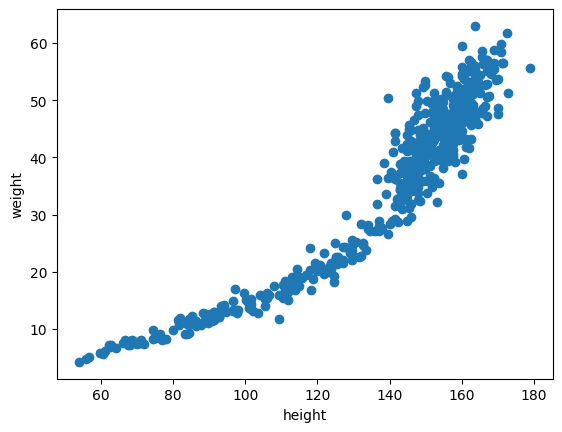

In [52]:
plt.scatter(howell['height'] , howell['weight'])
plt.xlabel("height")
plt.ylabel("weight")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [53]:
with pm.Model() as model_how:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_how = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

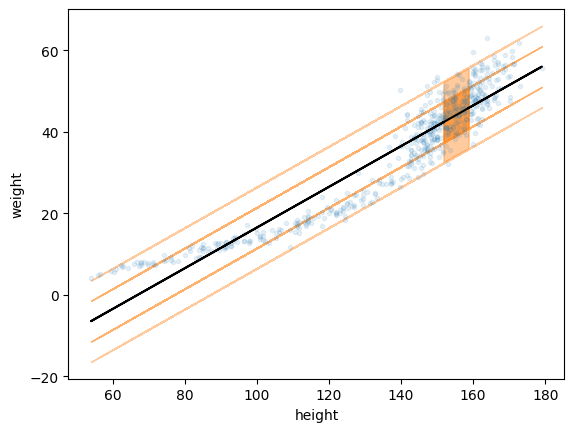

In [54]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_lba = az.extract(idata_how)

μ_m = posterior_lba["μ"].mean("sample").values
σ_m = posterior_lba["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [55]:
pm.sample_posterior_predictive(
    idata_how, model = model_how, extend_inferencedata=True
    )


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

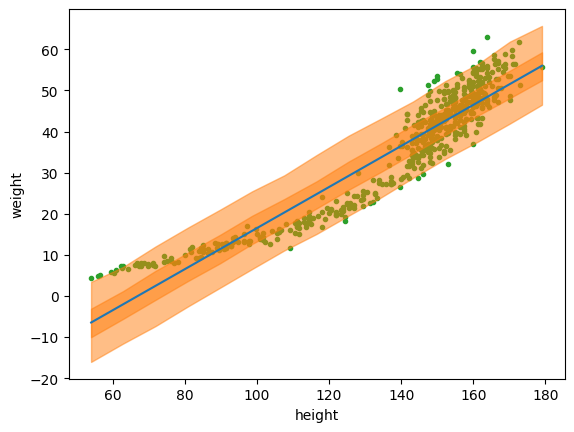

In [56]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_how.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_how.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

<Axes: xlabel='y_pred'>

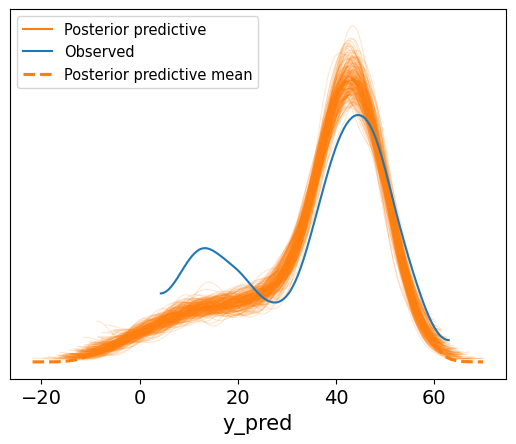

In [57]:
#posterior predictive check
az.plot_ppc(idata_how, num_pp_samples=200, colors=["C1", "C0", "C1"])

This model has a pretty good fit, however its peak is slightly higher than the observed and it doesn't capture the second smaller peak on the left as seen in the posterior predictive check. When looking at the linear model, we can see that it has a slight exponential curve to it that is not captured by just a line.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

<Axes: ylabel='height'>

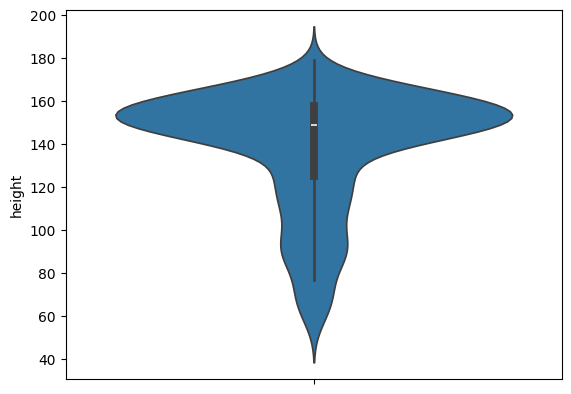

In [58]:
sns.violinplot(howell.height)

In [59]:
with pm.Model() as model_howexp:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.LogNormal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howexp = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

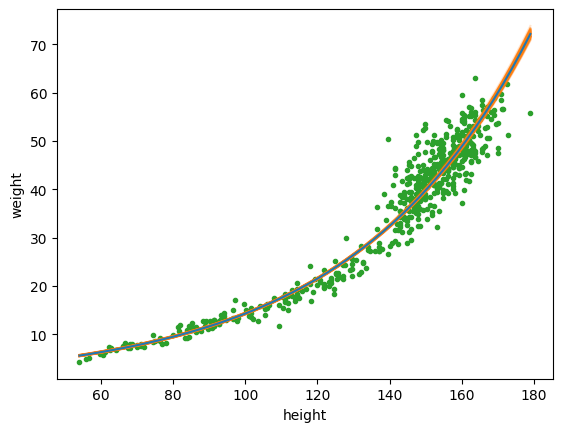

In [60]:
#grabs 100 posterior samples
posterior = az.extract(idata_howexp, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, np.exp(lines.T), c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, np.exp(mean_line), c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [61]:
pm.sample_posterior_predictive(
    idata_howexp, model = model_howexp, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

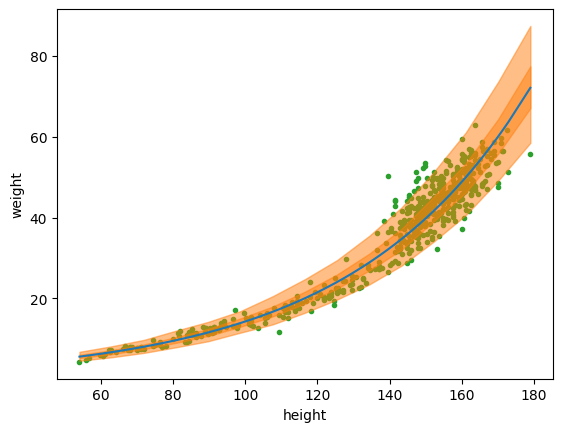

In [62]:
mean_line = idata_howexp.posterior["μ"].mean(("chain", "draw"))
heights = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(heights)
x = np.linspace(heights.min(), heights.max(), 15)
y_pred_q = idata_howexp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(heights[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], np.exp(mean_line[idx]), c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("height")
ax.set_ylabel("weight")

<Axes: xlabel='y_pred'>

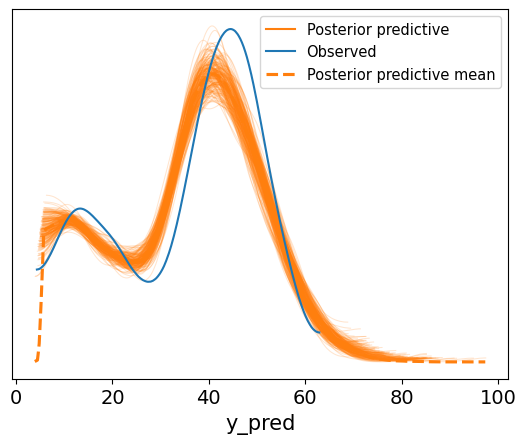

In [63]:
#posterior predictive check
az.plot_ppc(idata_howexp, num_pp_samples=200, colors=["C1", "C0", "C1"])

In the posterior, we can see that this model is a good fit. It has narrowed during the lower heights and widened during higher heights to better fit the data. It now follows the exponential trend of the data. It can be improved to capture some of the outer data, but overall it does a good job. From the posterior predictive check we can also see that this model appears to be a much better fit and even captures the second smaller peak. The line also captures the curve in the data better than before.